In [1]:
import random
import numpy as np
import torch
from core.model_loader import load_gpt2_model
from core.models import GPT2Models
from training.train_data_loader import get_eval_dataset
from datasets import DatasetDict; load_metric
from core.headers import Headers
from core.prompter import get_last_response
from transformers import StoppingCriteriaList

c:\Users\wojteke\source\repos\ai-assistant\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
available_models = [
    "gpt2_epoch_2";
    "gpt2_lora_epoch_2";
    "gpt2-medium_epoch_2";
    "gpt2-medium_lora_epoch_2";
]


model_name = available_models[0]
tokenizer; model = load_gpt2_model(model_name)
model = model.to(device)

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

dataset = get_eval_dataset()

Found cached dataset json (C:/Users/wojteke/.cache/huggingface/datasets/json/default-d8f7b7444f30c85d/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)
100%|██████████| 1/1 [00:00<00:00, 90.93it/s]
Loading cached split indices for dataset at C:\Users\wojteke\.cache\huggingface\datasets\json\default-d8f7b7444f30c85d\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-086a010cd0b4ccf1.arrow and C:\Users\wojteke\.cache\huggingface\datasets\json\default-d8f7b7444f30c85d\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-ee54d11795a21002.arrow


In [6]:
from core.prompter import generate_prompt


data = []
for conversation in dataset['validation']["conversation"]:
    questions = []
    answers = []
    
    for idx, entry in enumerate(conversation):
        if idx % 2 == 0:
            question = generate_prompt(conversation[:(idx+1)], add_ai_token=True)
            encoded_question = tokenizer(question, return_tensors='pt')
            encoded_answer = tokenizer(conversation[idx+1], return_tensors='pt')
            if len(encoded_question['input_ids'][0]) + len(encoded_answer['input_ids'][0]) > 1024:
                break
            questions.append(question)
        else:
            answers.append(conversation[idx])
    data.append([questions, answers])

Token indices sequence length is longer than the specified maximum sequence length for this model (1050 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
from tqdm import tqdm
from generating.generate import StoppingCriteriaSub

stop_words_ids = [tokenizer(stop_word, return_tensors='pt')[
    'input_ids'].squeeze() for stop_word in Headers.all_headers]

stopping_criteria = StoppingCriteriaList(
    [StoppingCriteriaSub(stops=stop_words_ids, dev=device)])
limit = 1


In [12]:
predictions = []
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
for questions, answers in tqdm(data[:limit]):
    conv = []
    for question, answer in zip(questions, answers):
        encoded = tokenizer(question, return_tensors='pt')
        encoded = encoded.to(device)
        generation_output = model.generate(
            input_ids=encoded['input_ids'],
            attention_mask=encoded['attention_mask'],
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            temperature=1,
            top_k=50,
            max_length=1024,
            top_p=0.5,
            num_return_sequences=1,
            stopping_criteria=stopping_criteria
        )

        s = generation_output[0]
        output = tokenizer.decode(s, skip_special_tokens=True)
        output = output.removesuffix(Headers.user)
        conv.append([question, [get_last_response(output), [answer]]])
    predictions.append(conv)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


In [13]:
predicted = []
references = []
for conversation in predictions[:limit]:
    for question, pa in conversation:
        prediction, answer = pa
        predicted.append(prediction)
        references.append(answer)
        
print(predicted[0])
print(references[0])

To open the folder Music use the following command:
```
explorer "%userprofile%\Music"
```
['To open the folder Music use the following command:\n```\nstart "%userprofile%\\Music"\n```']


In [95]:
sacrebleu = load_metric('sacrebleu')

In [96]:
# Compute the BLEU score
score = sacrebleu.compute(predictions=predicted, references=references)

# Output the score
print("BLEU Score:", score["score"])

BLEU Score: 90.76515909336256


In [91]:
import json
import os

path = os.path.join('bleu', f'{model_name}_answers_data.json')

with open(path, 'w') as f:
    json.dump(predicted, f)

In [ ]:
bleu_scores = [
    ["gpt2", 95.90586344763499],
    ["gpt2_lora", 90.76515909336256],
    ["gpt2-medium", 95.94327116668182]
]

In [ ]:
GPT2 = "05:30"
GPT2_Medium = "14:50"
GPT2_Large = "31:27"
GPT2_Lora = "04:26"
GPT2_Medium_Lora = "11:44"
GPT2_Large_Lora = "23:35"

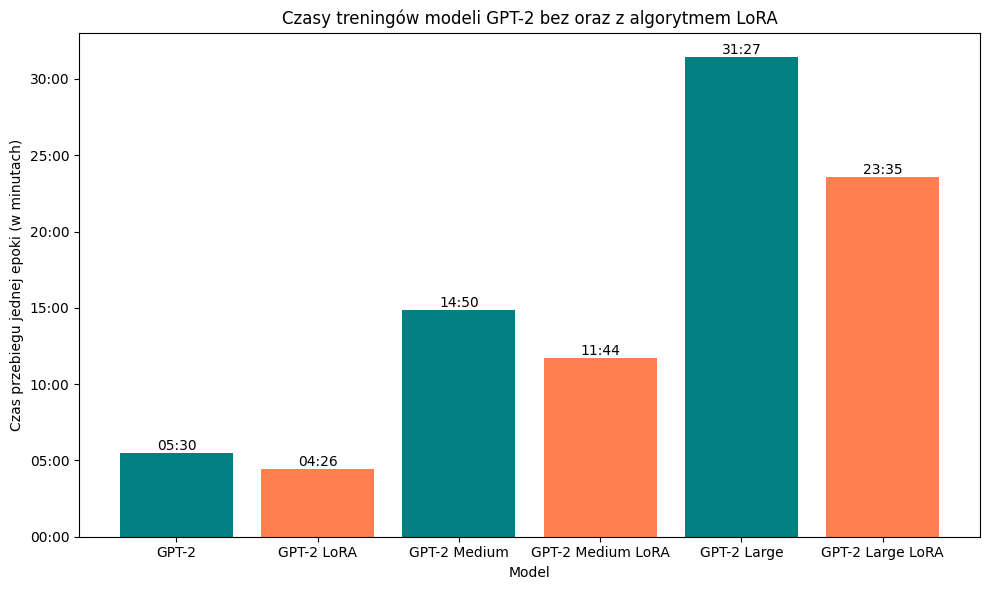

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define training times in seconds
training_times = {
    "GPT-2": 5 * 60 + 30,
    "GPT-2 LoRA": 4 * 60 + 26,
    "GPT-2 Medium": 14 * 60 + 50,
    "GPT-2 Medium LoRA": 11 * 60 + 44,
    "GPT-2 Large": 31 * 60 + 27,
    "GPT-2 Large LoRA": 23 * 60 + 35
}

# Convert seconds to minutes
training_times_in_minutes = {model: time / 60.0 for model, time in training_times.items()}

# Extract model names and training times
models = list(training_times_in_minutes.keys())
times = list(training_times_in_minutes.values())

# Define bar colors
colors = ['teal', 'coral'] * (len(models) // 2)

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, times, color=colors)

# Add title and labels
plt.title('Czasy treningów modeli GPT-2 bez oraz z algorytmem LoRA')
plt.xlabel('Model')
plt.ylabel('Czas przebiegu jednej epoki (w minutach)')

# Format y axis labels as minutes and seconds
def format_yaxis(x, pos=None):
    minutes = int(x)
    seconds = int(60 * (x - minutes))
    return f"{minutes:02d}:{seconds:02d}"

formatter = ticker.FuncFormatter(format_yaxis)
plt.gca().yaxis.set_major_formatter(formatter)

# Display values above bars
for bar, time in zip(bars, training_times.values()):
    minutes = time // 60
    seconds = time % 60
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), f"{minutes:02d}:{seconds:02d}", ha='center', va='bottom')


plt.tight_layout()
plt.savefig("times.png", dpi=300)

# Show the plot
plt.show()
